# Sentence Reconstruction

The purpose of this project is to take in input a sequence of words corresponding to a random permutation of a given english sentence, and reconstruct the original sentence.

The otuput can be either produced in a single shot, or through an iterative (autoregressive) loop generating a single token at a time.


CONSTRAINTS:
* No pretrained model can be used.
* The neural network models should have less the 20M parameters.
* No postprocessing should be done (e.g. no beamsearch)
* You cannot use additional training data.


BONUS PARAMETERS:

A bonus of 0-2 points will be attributed to incentivate the adoption of models with a low number of parameters.

# Dataset

The dataset is composed by sentences taken from the generics_kb dataset of hugging face. We restricted the vocabolary to the 10K most frequent words, and only took sentences making use of this vocabulary.

Download the dataset

In [ ]:
from datasets import load_dataset
from keras.layers import TextVectorization
import tensorflow as tf
import numpy as np
np.random.seed(42)
ds = load_dataset('generics_kb',trust_remote_code=True)['train']

2024-06-10 18:44:03.486140: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.

To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

2024-06-10 18:44:04.239467: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Filter row with length greater than 8.


In [ ]:
ds = ds.filter(lambda row: len(row["generic_sentence"].split(" ")) > 8 )
corpus = [ '<start> ' + row['generic_sentence'].replace(","," <comma>") + ' <end>' for row in ds ]
corpus = np.array(corpus)


Create a tokenizer and Detokenizer

In [ ]:
tokenizer=TextVectorization( max_tokens=10000, standardize="lower_and_strip_punctuation", encoding="utf-8",) #con il max prende le piu frequenti. ordina i token del vocab dal piu frequente al meno frequente
tokenizer.adapt(corpus)

class TextDetokenizer:
    def __init__(self, vectorize_layer):
        self.vectorize_layer = vectorize_layer
        vocab = self.vectorize_layer.get_vocabulary()
        self.index_to_word = {index: word for index, word in enumerate(vocab)}

    def __detokenize_tokens(self, tokens):
        def check_token(t):
          if t == 3:
            s="<start>"
          elif t == 2:
            s="<end>"
          elif t == 7:
            s="<comma>"
          else:
            s=self.index_to_word.get(t, '[UNK]')
          return s

        return ' '.join([ check_token(token) for token in tokens if token != 0])

    def __call__(self, batch_tokens):
       return [self.__detokenize_tokens(tokens) for tokens in batch_tokens]


detokenizer = TextDetokenizer( tokenizer )
sentences = tokenizer( corpus ).numpy()

2024-06-10 18:44:31.998541: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20974 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:35:00.0, compute capability: 8.9


Remove from corpus the sentences where any unknow word appears

In [ ]:
mask = np.sum( (sentences==1), axis=1) >= 1
original_data = np.delete( sentences, mask , axis=0)

In [ ]:
original_data.shape

(241236, 28)

Shuffle the sentences

In [ ]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, data, mode="training", batch_size=32, shuffle=True, seed=42):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed
        self.mode = mode
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        data_batch = np.array([self.data[k] for k in indexes])
        #copy of ordered sequences
        result = np.copy(data_batch)
        #shuffle only the relevant positions for each batch
        for i in range(data_batch.shape[0]):
            np.random.shuffle(data_batch[i,1:data_batch[i].argmin() - 1])

        if self.mode=="training" or self.mode=="validation":
            # teacher forcing
            target = np.array([np.append(sentence[1:], 0) for sentence in result])
            data_batch_mask = np.where(data_batch==0,0,1)
            result_mask = np.where(result==0,0,1)
            return (data_batch , result, data_batch_mask, result_mask), target

        elif self.mode=="test":
            return data_batch, result

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            if self.seed is not None:
                np.random.seed(self.seed)
            np.random.shuffle(self.indexes)

In [ ]:
# Make a random permutation of training and test set
np.random.seed(42)
# Shuffle the all data
shuffled_indices = np.random.permutation(len(original_data))
shuffled_data = original_data[shuffled_indices]

In [ ]:
train_generator = DataGenerator(shuffled_data[:220000],batch_size=128)
test_generator = DataGenerator(shuffled_data[220000:], mode='test', batch_size=128)

In [ ]:
x, y = test_generator.__getitem__(1)
x = detokenizer(x)
y = detokenizer(y)

for i in range(7):
  print("original: ", y[i])
  print("shuffled: ", x[i])
  print("\n")


original:  <start> all organisms cause changes in the environment in which they live <end>

shuffled:  <start> changes cause they live which the organisms all in environment in <end>





original:  <start> most business people have meetings on a daily basis <end>

shuffled:  <start> basis daily business on meetings a people have most <end>





original:  <start> humans thrive on stress because it makes life more interesting <end>

shuffled:  <start> it humans interesting because life makes stress thrive more on <end>





original:  <start> some bacteria can take up dna from the environment <comma> a process called transformation <end>

shuffled:  <start> environment bacteria some from the called dna process transformation <comma> a take up can <end>





original:  <start> flowers are rich source of vitamin c and have sweet taste <end>

shuffled:  <start> sweet flowers are and c source vitamin have taste rich of <end>





original:  <start> antihistamines make a good sleep aid for 

# Metrics

Let s be the source string and p your prediction. The quality of the results will be measured according to the following metric:

1.  look for the longest substring w between s and p
2.  compute |w|/max(|s|,|p|)

If the match is exact, the score is 1.

When computing the score, you should NOT consider the start and end tokens.



The longest common substring can be computed with the SequenceMatcher function of difflib, that allows a simple definition of our metric.

In [ ]:
from difflib import SequenceMatcher

def score(s,p):
  match = SequenceMatcher(None, s, p).find_longest_match()
  #print(match.size)
  return (match.size/max(len(p),len(s)))

Let's do an example.

In [ ]:
original = "at first henry wanted to be friends with the king of france"
generated = "henry wanted to be friends with king of france at the first"

print("your score is ",score(original,generated))

your score is  0.5423728813559322


The score must be computed as an average of at least 3K random examples taken form the test set.

# What to deliver

You are supposed to deliver a single notebook, suitably commented.
The notebook should describe a single model, although you may briefly discuss additional attempts you did.

The notebook should contain a full trace of the training.
Weights should be made available on request.

You must also give a clear assesment of the performance of the model, computed with the metric that has been given to you.

# Good work!

In [ ]:
import tensorflow as tf
import keras_nlp
import keras
import numpy as np
from keras.callbacks import EarlyStopping


The model is instantiated with the following parameters, each selected through a process of trial and error by training various models with different parameter combinations.

Two of the most influential parameters were the number of attention heads and the dropout rate:

•	Number of Heads: This parameter significantly affects how well the model captures underlying dependencies in sequences.

•	Dropout Rate: This parameter determines the model's susceptibility to overfitting and underfitting.

In [ ]:
BATCH_SIZE = 64
EPOCHS = 200
MAX_SEQUENCE_LENGTH = 28
VOCAB_SIZE = 10000
num_layers = 6
EMBED_DIM = 256
INTERMEDIATE_DIM = 1550
NUM_HEADS = 8
DROPOUT = 0.1

For this project, I opted to implement a neural network based on the original Transformer model, as introduced in the influential paper:

	•	Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, Ł., & Polosukhin, I. (2017). Attention is All You Need. Advances in Neural Information Processing Systems, 30.

Initially, I replicated the model as outlined in the paper and then made iterative improvements, resulting in the current version of the network.

One of the first enhancements I implemented was modifying the DataGenerator class to better fit the model’s architecture. The __getitem__() method now supports two distinct modes based on its usage:

	•	mode=“training”: This mode is designed for creating the training generator used in model.fit(). It also generates masks for padding elements and shifts the target sequence one token to the right, facilitating the teacher forcing technique.
	•	mode=“test”: This mode is intended for creating both the test generator and the validation generator used for predictions. The validation data is a subset of the training data from the dataset.

In [ ]:
def get_transformer():
    padding_mask_enc = keras.Input( shape=(None,), name="padding_mask_enc",)
    padding_mask_dec = keras.Input( shape=(None,),name="padding_mask_dec",)
    # Encoder
    encoder_inputs = keras.Input(shape=(None,), name="encoder_inputs")
    embedding = keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM)
    x = embedding(encoder_inputs)
    for i in range(num_layers-1):
        x = keras_nlp.layers.TransformerEncoder(
            intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS,dropout=DROPOUT
        )(inputs=x, padding_mask=padding_mask_enc)
    encoder_outputs = keras_nlp.layers.TransformerEncoder(
            intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS,dropout=DROPOUT
        )(inputs=x, padding_mask=padding_mask_enc)


    # Decoder
    decoder_inputs = keras.Input(shape=(None,), name="decoder_inputs")
    decoder_embedding = embedding(decoder_inputs)
    x = keras_nlp.layers.PositionEmbedding(
    sequence_length=MAX_SEQUENCE_LENGTH)(decoder_embedding)
    x += decoder_embedding
    for i in range(num_layers):
        x = keras_nlp.layers.TransformerDecoder(
            intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS,dropout=DROPOUT
        )(decoder_sequence=x, encoder_sequence=encoder_outputs, decoder_padding_mask=padding_mask_dec, encoder_padding_mask=padding_mask_enc)
    decoder_outputs = keras.layers.Dense(VOCAB_SIZE, activity_regularizer = 'l2', activation="softmax")(x)
    transformer = keras.Model(
        [encoder_inputs, decoder_inputs, padding_mask_enc, padding_mask_dec],
        decoder_outputs,
        name="transformer",
    )
    return transformer

In [ ]:
transformer = get_transformer()

The custom scheduler often caused the model to get stuck in plateaus. However, by utilizing the restart technique with CosineDecayRestarts(), the model was able to break free from these plateaus, leading to a marked improvement in overall performance. This adjustment resulted in a significant increase in both training accuracy and the final test score, with an average gain of 0.02.

In [ ]:
class MyLRSchedule(keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
restart_scheduler = keras.optimizers.schedules.CosineDecayRestarts(8e-04,3e04,t_mul=0.5,m_mul=0.01)


In [ ]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=False, reduction='none')
    loss = loss_object(label, pred)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss

def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
train_generator = DataGenerator(shuffled_data[:217000], batch_size=200)
val_generator = DataGenerator(shuffled_data[217000:220000], batch_size=1000, mode='test')

In [ ]:
def clean_sentence(x):
    x = x.replace('<start>', '').replace('<end>', '').replace('<pad>', '').strip()
    return x

In [ ]:
class Translator(tf.Module):
    def __init__(self, transformer, tokenizer):
        self.transformer = transformer
        self.tokenizer = tokenizer

    def __call__(self, sentences, max_length=28):
        batch_size = sentences.shape[0]

        # generate word list for each sentence
        bow = [[word for word in sentence if word not in [3, 2, 0]] for sentence in sentences]
        # starting vector for prediction, it contains the sos index
        #output = [[3]+[0]*(MAX_SEQUENCE_LENGTH-1) for _ in range(batch_size)]
        output = [[3] for _ in range(batch_size)]

        # during inference, output will be filled with the final sentence.

        for i in range(1, max_length):
            # (enc_input, dec_input)

            predictions = np.array(self.transformer((np.array(sentences), np.array(output), np.where(np.array(sentences)==0,0,1),np.where(np.array(output)==0,0,1)), training=False))
            # remove useless dimensions
            predictions = predictions[:, -1, :]
            for j in range(batch_size):
                if len(bow[j]) == 0:
                    # no more words to use
                    cand_token = 2
                else:
                    # choose index with highest score
                    s_prediction = predictions[j, np.array(bow[j])]
                    cand_index = np.argmax(s_prediction)
                    cand_token = bow[j][cand_index]
                    del bow[j][cand_index]
                #output[j][i] = cand_token
                output[j].append(cand_token)
        return output

The ValidationCallback played a crucial role in significantly enhancing the model’s performance. This custom callback monitors the model’s progress during training by evaluating its predictions on the validation set.
This callback enables prolonged training sessions while preventing overfitting on the validation data, resulting in an average test score increase of 0.03.

In [ ]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
import numpy as np

class ValidationCallback(Callback):
    def __init__(self, tokenizer,generator, batch_size, max_patience):
        super(ValidationCallback, self).__init__()
        self.tokenizer = tokenizer
        self.generator = generator
        self.batch_size = batch_size
        self.max_patience = max_patience
        self.patience = 0
        self.max_score = 0

    def on_epoch_end(self, epoch, logs=None):
        score_batch_size = self.batch_size
        total_val_size = 3000
        tot_score = 0
        self.model.save_weights('current_model.weights.h5')
        model = get_transformer()
        model.load_weights('current_model.weights.h5')
        translator = Translator(model, self.tokenizer)
        for i in range(total_val_size // score_batch_size):
            shuffled, ordered = self.generator[i]
            y_pred = translator(shuffled)
            pred_sentences = detokenizer(y_pred)
            original_sentences = detokenizer(ordered)
            b_score = 0
            for j in range(score_batch_size):
                b_score += score(clean_sentence(original_sentences[j]), clean_sentence(pred_sentences[j]))

            tot_score += b_score
            print(f"\nValidation Score after batch {i+1}: {tot_score / ((i+1) * score_batch_size)}")
        final_score = tot_score / total_val_size
        if final_score >= self.max_score:
            self.patience = 0
            self.max_score = final_score
            self.model.save_weights('best_model.weights.h5')
        else:
            if self.patience == self.max_patience:
                self.model.load_weights('best_model.weights.h5')
                self.model.stop_training = True
            else:
                self.patience +=1
        logs['val_score'] = final_score

In [ ]:
score_callback = ValidationCallback(tokenizer=tokenizer,generator=val_generator,batch_size=1000, max_patience=8)

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_28        │ (None, None, 256) │  2,560,000 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │ decoder_inputs[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ padding_mask_enc    │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 256) │  1,059,598 │ embedding_28[0][… │
│ (TransformerEncode… │                   │            │ padding_mask_enc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 256) │  1,059,598 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ padding_mask_enc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 256) │  1,059,598 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ padding_mask_enc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 256) │  1,059,598 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ padding_mask_enc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding… │ (None, None, 256) │      7,168 │ embedding_28[1][… │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 256) │  1,059,598 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ padding_mask_enc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_28 (Add)        │ (None, None, 256) │          0 │ position_embeddi… │
│                     │                   │            │ embedding_28[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ padding_mask_dec    │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 256) │  1,059,598 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ padding_mask_enc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 256) │  1,323,278 │ add_28[0][0],     │
│ (TransformerDecode… │                   │            │ padding_mask_dec… │
│                     │                   │            │ padding_mask_enc… │
│                     │                   │            │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 256) │  1,323,278 │ transformer_deco… │
│ (TransformerDecode… │                   │            │ padding_mask_dec… │
│                     │                   │            │ padding_mask_enc… │
│                     │                   │            │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 19,434,424 (74.14 MB)

 Trainable params: 19,434,424 (74.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

  self._warn_if_super_not_called()

W0000 00:00:1718048761.114022    8384 assert_op.cc:38] Ignoring Assert operator compile_loss/masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert

I0000 00:00:1718048850.659306    8384 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_80', 168 bytes spill stores, 168 bytes spill loads

ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_77', 48 bytes spill stores, 48 bytes spill loads




1085/1085 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 5.8896 - masked_accuracy: 0.2630

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1000, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?

  warnings.warn(




Validation Score after batch 1: 0.3733248206567494



Validation Score after batch 2: 0.37327319030099393



Validation Score after batch 3: 0.37435333301787105

1085/1085 ━━━━━━━━━━━━━━━━━━━━ 241s 116ms/step - loss: 5.8888 - masked_accuracy: 0.2631 - val_score: 0.3744

Epoch 2/200

1085/1085 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 3.5163 - masked_accuracy: 0.6691

Validation Score after batch 1: 0.4186246587297341



Validation Score after batch 2: 0.41462534626975434



Validation Score after batch 3: 0.41790206841907834

1085/1085 ━━━━━━━━━━━━━━━━━━━━ 127s 117ms/step - loss: 3.5162 - masked_accuracy: 0.6691 - val_score: 0.4179

Epoch 3/200

1085/1085 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 3.1344 - masked_accuracy: 0.7584

Validation Score after batch 1: 0.4501660724277956



Validation Score after batch 2: 0.4460021108407554



Validation Score after batch 3: 0.4455957087568995

1085/1085 ━━━━━━━━━━━━━━━━━━━━ 127s 117ms/step - loss: 3.1343 - masked_accuracy: 0.7584 - val_scor

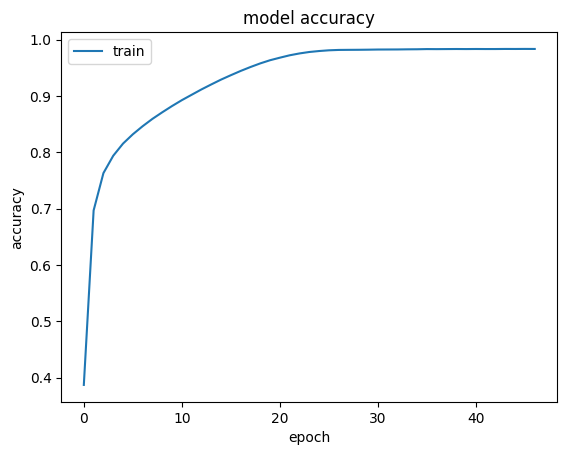

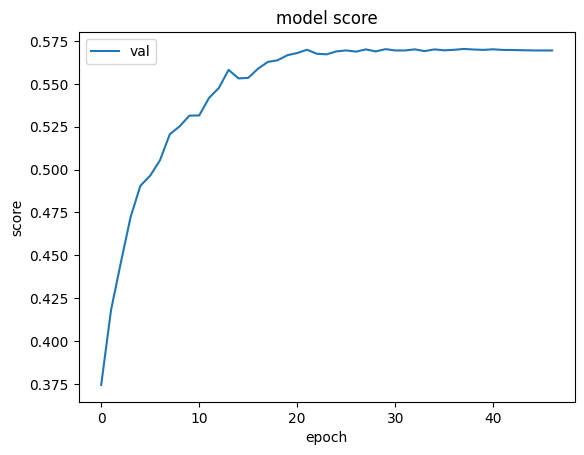

In [ ]:
import matplotlib.pyplot as plt
transformer.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True) #stop if validation loss does not improve for 5 epochs
opt = keras.optimizers.Adam(learning_rate=restart_scheduler,beta_1=0.9, beta_2=0.98,epsilon=1e-09)
transformer.compile(optimizer=opt, loss=masked_loss, metrics=[masked_accuracy])
history = transformer.fit(train_generator,epochs=EPOCHS,callbacks=score_callback)
#  "Accuracy"
plt.plot(history.history['masked_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['val_score'])
plt.title('model score')
plt.ylabel('score')
plt.xlabel('epoch')
plt.legend(['val'], loc='upper left')
plt.show()


In [ ]:
score_batch_size = 500
total_test_size = 3000
score_ = 0
translator=Translator(transformer,tokenizer)
test_generator = DataGenerator(shuffled_data[220000:], mode='test', batch_size=score_batch_size)
for i in range(total_test_size//score_batch_size):
    shuffled, ordered = test_generator[i]
    y_pred = translator(shuffled)
    b_score = 0                   # score associated with each batch

    pred_sentences = detokenizer(y_pred)
    original_sentences = detokenizer(ordered)

    for j in range(score_batch_size) :
        b_score += score(clean_sentence(original_sentences[j]), clean_sentence(pred_sentences[j]))

    score_ += b_score
    print("\n====BATCH OVER====")
    print("Score as of batch ", i, ": ", score_/((i+1)*score_batch_size))

score_ = score_/total_test_size
print("\n====ALL OVER====")
print("Final score: ", score_)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (500, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?

  warnings.warn(




====BATCH OVER====

Score as of batch  0 :  0.5751883901435415



====BATCH OVER====

Score as of batch  1 :  0.5836768526619389



====BATCH OVER====

Score as of batch  2 :  0.57737559133173



====BATCH OVER====

Score as of batch  3 :  0.5786266152461692



====BATCH OVER====

Score as of batch  4 :  0.5762958641176169



====BATCH OVER====

Score as of batch  5 :  0.5732276251260583



====ALL OVER====

Final score:  0.5732276251260583


# Conclusion

My final score is: 0.5732276251260583

After numerous experiments and iterations, I have developed a final model using the Transformer architecture as proposed in the paper Attention Is All You Need. While I also experimented with different architectures, such as LSTM, their performance was significantly worse.

To further enhance the model’s performance, I incorporated a custom Validation Callback, which allowed real-time monitoring of the model’s performance on the validation set. This led to higher accuracy and better test performance. Additionally, I adopted the CosineDecay learning rate schedule to personalize the learning rate and help the model overcome encountered plateaus.

The model achieved average performance overall. Parameter tuning efforts, such as:

•	Increasing the number of attention heads

•	Increasing the dropout rate

resulted in similar or lower scores.

For completeness I would like to say that I was inspired by the following papers:

* https://aclanthology.org/2021.naacl-main.134.pdf
* https://arxiv.org/pdf/1706.03762.pdf